## Installing Modules

In [1]:
!pip install spacy==3
!python -m spacy download en_core_web_sm
!pip install pytorch_lightning torchmetrics tableprint

2021-06-17 03:13:14.193718: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Imports

In [2]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import pandas as pd
import sys, os, pickle
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

import spacy
nlp = spacy.load('en_core_web_sm')

import pytorch_lightning as pl
import torchmetrics

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import tableprint as tp

import collections


# Manual Seed
SEED = 43
torch.manual_seed(SEED)

## Loading Data

Files have been saved to google drive for faster access!

In [3]:
!gdown --id 1HmYahgrwNcZREWtUTr6H11ygJufuFcTc
!gdown --id 14hb3DlvmMeEvWhNYXAZjhE3MFS1T8Nte
!gdown --id 1xwvuoXp35tjE-rV7oAOkq6T42qli344P

Downloading...
From: https://drive.google.com/uc?id=1HmYahgrwNcZREWtUTr6H11ygJufuFcTc
To: /content/datasetSentences.txt
100% 1.29M/1.29M [00:00<00:00, 83.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=14hb3DlvmMeEvWhNYXAZjhE3MFS1T8Nte
To: /content/sentiment_labels.txt
3.26MB [00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xwvuoXp35tjE-rV7oAOkq6T42qli344P
To: /content/dictionary.txt
12.0MB [00:00, 106MB/s] 


The sentiments are read for the phrases (with their ids as the mapping index)

In [4]:
sentiment_labels = pd.read_csv("sentiment_labels.txt", sep="|", header=0)
sentiment_labels.columns = ["id", "sentiment"]
sentiment_labels.head()

,id,sentiment
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


The sentiments are mapped onto a discrete set of 5-values (and will be referred to as the label)

In [5]:
sentiment_labels["label"] = pd.cut(sentiment_labels.sentiment, [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                           include_lowest=True,
                                           labels=[0, 1, 2, 3, 4])
sentiment_labels.drop('sentiment', inplace=True, axis=1)
sentiment_labels.head()

,id,label
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


The sentences are read here!

In [6]:
sentences = pd.read_csv("datasetSentences.txt", index_col="sentence_index",sep="\t")
sentences.head()

,sentence
sentence_index,
1,The Rock is destined to be the 21st Century 's...
2,The gorgeously elaborate continuation of `` Th...
3,Effective but too-tepid biopic
4,If you sometimes like to go to the movies to h...
5,"Emerges as something rare , an issue movie tha..."


The `dictionary.txt` file maps the phrases to the ids

In [7]:
dictionary = pd.read_csv("dictionary.txt", sep="|", header=0)
dictionary.columns = ["phrase", "id"]
dictionary.head()

,phrase,id
0,! ',22935
1,! '',18235
2,! Alas,179257
3,! Brilliant,22936
4,! Brilliant !,40532


Here, the mapping is done from phrase ids to phrases themselves, followed by mapping of sentences to the labels.

In [8]:
sentence_phrase_merge = pd.merge(sentences, dictionary, left_on='sentence', right_on='phrase')
dataset = pd.merge(sentence_phrase_merge, sentiment_labels, on='id')
dataset.head()

,sentence,phrase,id,label
0,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,3
1,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,4
2,Effective but too-tepid biopic,Effective but too-tepid biopic,13995,2
3,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123,3
4,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999,4


The dataset is cleaned

In [9]:
dataset['sentence_cleaned'] = dataset['sentence'].str.replace(r"\s('s|'d|'re|'ll|'m|'ve|n't)\b", lambda m: m.group(1))
dataset.head()

,sentence,phrase,id,label,sentence_cleaned
0,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,3,The Rock is destined to be the 21st Century's ...
1,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,4,The gorgeously elaborate continuation of `` Th...
2,Effective but too-tepid biopic,Effective but too-tepid biopic,13995,2,Effective but too-tepid biopic
3,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123,3,If you sometimes like to go to the movies to h...
4,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999,4,"Emerges as something rare , an issue movie tha..."


Only the cleaned sentences and the labels are retained

In [10]:
dataset.drop(['phrase', 'id', 'sentence'], inplace=True,axis=1)
dataset.columns = ["label", "sentence"]
dataset.head()

,label,sentence
0,3,The Rock is destined to be the 21st Century's ...
1,4,The gorgeously elaborate continuation of `` Th...
2,2,Effective but too-tepid biopic
3,3,If you sometimes like to go to the movies to h...
4,4,"Emerges as something rare , an issue movie tha..."


## Dataset Preview

Let's just preview the dataset.

In [11]:
dataset.head()

,label,sentence
0,3,The Rock is destined to be the 21st Century's ...
1,4,The gorgeously elaborate continuation of `` Th...
2,2,Effective but too-tepid biopic
3,3,If you sometimes like to go to the movies to h...
4,4,"Emerges as something rare , an issue movie tha..."


In [12]:
dataset.shape

(11286, 2)

In [13]:
dataset.label.value_counts()

1    2971
3    2966
2    2144
4    1773
0    1432
Name: label, dtype: int64

## Defining Fields

In [14]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.3)

In [15]:
print(f'Number of Train Examples: {len(train_data)}')
print(f'Number of Test Examples: {len(test_data)}')

Number of Train Examples: 7900
Number of Test Examples: 3386


In [16]:
from torchtext.data.utils import get_tokenizer
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [17]:
def build_vocab(df, tokenizer, **vocab_kwarg):
    
    token_freqs = collections.Counter()
    
    for index, row  in df.iterrows():
        tokens = tokenizer(row['sentence'])
        token_freqs.update(tokens)
        
    vocab = torchtext.vocab.Vocab(token_freqs, **vocab_kwarg)
    
    return vocab

In [18]:
en_vocab = build_vocab(train_data, en_tokenizer)

In [19]:
def data_process(df):
    data = []
    for index, row in df.iterrows():
      en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(row['sentence'])],
                                dtype=torch.long)
      label = torch.tensor(row['label'], dtype=torch.long)
      data.append((en_tensor_, label))
    return data

train_dataset = data_process(train_data)
# val_dataset = data_process(val_df)
test_dataset = data_process(test_data)

Let's define the collator that will be used to create batches

In [20]:
class Collator:
    def __init__(self, pad_idx):
        
        self.pad_idx = pad_idx
        
    def collate(self, batch):
        text, labels = zip(*batch)
        labels = torch.LongTensor(labels)
        text = nn.utils.rnn.pad_sequence(text, padding_value=self.pad_idx, batch_first=True)
        return text, labels

The collator is intitialized along with the padding token

In [21]:
pad_token = '<PAD>'
pad_idx = en_vocab[pad_token]
print(pad_idx)
collator = Collator(pad_idx)

0


Build the dataset

In [22]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size,
                                            shuffle = True,
                                            collate_fn = collator.collate
                                          )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size,
                                            shuffle = False,
                                            collate_fn = collator.collate
                                          )

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Save the vocabulary for later use

In [24]:
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(en_vocab.stoi, tokens)

## Defining Our Model

### Boilerplate code for PyTorchLightning

In [25]:
class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_accm = torchmetrics.Accuracy()
        self.valid_accm = torchmetrics.Accuracy()
        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        input, target = batch 
        output = self(input)
        loss_train = self.loss(output, target).squeeze() 
        predictions = torch.argmax(output, dim=1)
        acc_train = self.train_accm(predictions, target)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        input, target = batch  
        output = self(input)
        loss_valid = self.loss(output, target).squeeze() 
        predictions = torch.argmax(output, dim=1)
        acc_valid = self.valid_accm(predictions, target)
        return {"loss": loss_valid, "p": predictions, "y": target}
    
    def training_epoch_end(self, outputs):
        self.train_acc = self.train_accm.compute() * 100
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.train_accm.reset()
    
    def validation_epoch_end(self, outputs):
        if trainer.running_sanity_check:
            return
        valid_acc = self.valid_accm.compute() * 100
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train Acc': self.train_acc, 'Train Loss': self.avg_train_loss,  'Valid Acc': valid_acc, 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
            self.table_context = tp.TableContext(headers=['epoch', 'Train Acc', 'Train Loss', 'Valid Acc', 'Valid Loss'])
            self.table_context.__enter__()
        self.table_context([self.current_epoch+1, self.train_acc.item(), self.avg_train_loss.item(), valid_acc.item(), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        self.valid_accm.reset()
        if self.current_epoch == self.trainer.max_epochs - 1:
            self.validation_end(outputs)
    
    def validation_end(self, outputs):
        pb = [x['p'] for x in outputs]
        yb = [x['y'] for x in outputs]
        p = torch.cat(pb, 0).view(-1).cpu()
        y = torch.cat(yb, 0).view(-1).cpu()
        self.table_context.__exit__()
        # confusion matrix here!
        cm = confusion_matrix(y.tolist(), p.tolist())
        df_cm = pd.DataFrame(cm, columns=np.unique(y), index = np.unique(y))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (10,7))
        sns.set(font_scale=1.4)#for label size
        fig_ = sns.heatmap(df_cm, annot=True, cmap="Blues",annot_kws={"size": 16})

### The Actual Model

In [26]:
class classifier(TL):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(classifier, self).__init__()
        
        self.loss = nn.CrossEntropyLoss()
        self.lr = 1e-3
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, text):

        embedded = self.embedding(text)
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), enforce_sorted=False, batch_first=True)
        packed_output, (hidden, cell) = self.encoder(embedded)
        dense_outputs = self.fc(hidden)   
        return dense_outputs[-1]
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

In [27]:
len(en_vocab)

16378

In [28]:
# Define hyperparameters
size_of_vocab = len(en_vocab)
embedding_dim = 100
num_hidden_nodes = 20
num_output_nodes = 5
num_layers = 2
dropout = 0.4

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

## Model Checkpoint

This saves the best model (best => model with lowest val loss)

In [29]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./content',
    # filename='sst-{epoch:02d}-{val_loss:.2f}',
    filename='sst',
    mode='min'
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | train_accm | Accuracy         | 0     
1 | valid_accm | Accuracy         | 0     
2 | loss       | CrossEntropyLoss | 0     
3 | embedding  | Embedding        | 1.6 M 
4 | encoder    | LSTM             | 13.1 K
5 | fc         | Linear           | 105   
------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.604     Total estimated model params size (MB)


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train Acc │  Train Loss │   Valid Acc │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      26.481 │      1.5738 │      25.307 │      1.5768 │


│           2 │       26.62 │      1.5705 │      26.019 │      1.5752 │


│           3 │       26.57 │        1.57 │      27.082 │      1.5743 │


│           4 │      26.962 │      1.5692 │      25.842 │      1.5763 │


│           5 │      27.215 │      1.5663 │      25.694 │      1.5767 │


│           6 │      27.316 │      1.5574 │      26.403 │      1.5716 │


│           7 │      33.063 │      1.4942 │      28.529 │      1.5997 │


│           8 │      42.949 │      1.3551 │      29.829 │      1.6569 │


│           9 │      52.823 │      1.1813 │      30.006 │      1.7388 │


│          10 │      62.241 │      1.0161 │      30.035 │      1.8491 │


│          11 │      68.633 │     0.87763 │      31.276 │      2.0389 │


│          12 │      74.405 │     0.75788 │      30.951 │      2.0378 │


│          13 │      78.848 │     0.65064 │      32.162 │      2.2488 │


│          14 │      81.962 │      0.5633 │      31.719 │      2.3266 │


│          15 │      85.266 │      0.4895 │       31.66 │      2.5752 │


│          16 │      86.304 │     0.44724 │      30.892 │      2.5232 │


│          17 │      87.722 │     0.41379 │      31.512 │      2.6002 │


│          18 │      88.975 │     0.37405 │      31.896 │      2.6794 │


│          19 │       90.57 │     0.32838 │      32.132 │       2.794 │


│          20 │      91.608 │     0.29901 │      31.571 │      2.7736 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

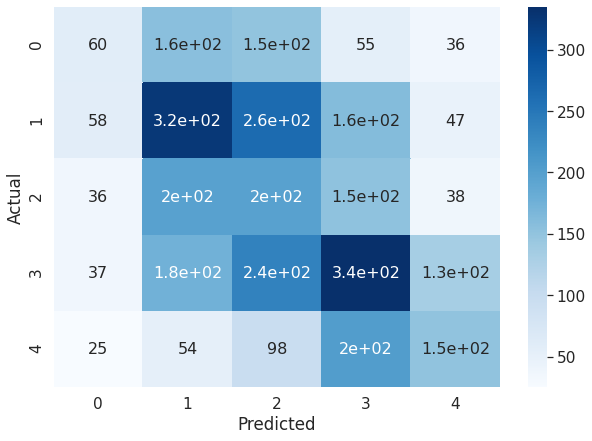

In [30]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2 Assign 7_1_TL', version=0)
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=test_loader)
checkpoint_callback.best_model_path

## Model Training and Evaluation

First define the optimizer and loss functions

In [31]:
root='./csv_logs/' + 'END2 Assign 7_1_TL' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

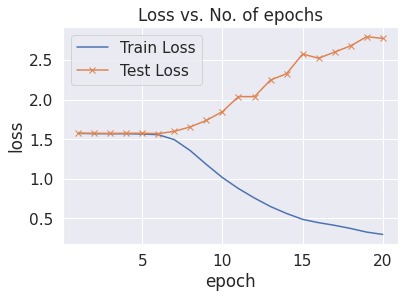

In [32]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

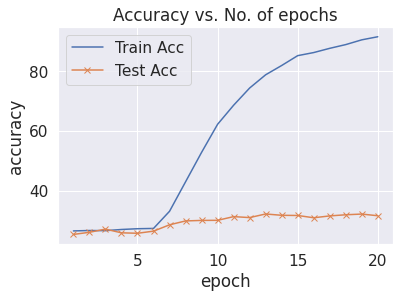

In [33]:
plt.plot(metrics['epoch'], metrics['Train Acc'], label="Train Acc")
plt.plot(metrics['epoch'], metrics['Valid Acc'], '-x', label="Test Acc")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy vs. No. of epochs');

## Model Testing

In [34]:
#load weights and tokenizer

model = model.to(device)
model.eval()
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 
def classify_sentence(sentence):
    
    categories = {0: "Worst", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Great"}
    
    # tokenize the sentence 
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T    
    # tensor = sentence.unsqueeze(1).T.to(device)   
    # Get the model prediction
    with torch.no_grad():
      prediction = model(tensor)

      _, pred = torch.max(prediction, 1) 
    
    # return categories[pred.item()]
    return pred.item()

In [35]:
classify_sentence("This is something you will regret.")

2

In [36]:
for i in np.random.randint(0,len(test_data),10):
  sent = test_data.iloc[i,1]
  label = test_data.iloc[i,0]
  pred = classify_sentence(sent)
  print(f'Sentence: {sent[:60]} \t Predicted: {pred} \t Actual: {label}')

Sentence: The movie is concocted and carried out by folks worthy of sc 	 Predicted: 0 	 Actual: 0
Sentence: Not even Felinni would know what to make of this Italian fre 	 Predicted: 1 	 Actual: 0
Sentence: Some elements of it really blow the big one , but other part 	 Predicted: 3 	 Actual: 2
Sentence: It's that good . 	 Predicted: 2 	 Actual: 4
Sentence: Tries to work in the same vein as the brilliance of Animal H 	 Predicted: 1 	 Actual: 0
Sentence: `` Birthday Girl '' is an actor's movie first and foremost . 	 Predicted: 4 	 Actual: 3
Sentence: Thanks largely to Williams , all the interesting development 	 Predicted: 0 	 Actual: 0
Sentence: The off-center humor is a constant , and the ensemble gives  	 Predicted: 1 	 Actual: 3
Sentence: The boys ' sparring , like the succession of blows dumped on 	 Predicted: 1 	 Actual: 2
Sentence: They should have found Orson Welles ' great-grandson . 	 Predicted: 1 	 Actual: 2
